In [5]:
import pandas as pd

df = pd.read_excel('FRED.xlsx')
df.dropna(subset=['DGS10'], inplace=True)  # Remove rows where DGS10 is null
df.rename(columns={'observation_date': 'Date'}, inplace=True)
display(df.head())
print(df.shape)

,Date,DGS10
0,1962-01-02,4.06
1,1962-01-03,4.03
2,1962-01-04,3.99
3,1962-01-05,4.02
4,1962-01-08,4.03


(15872, 2)


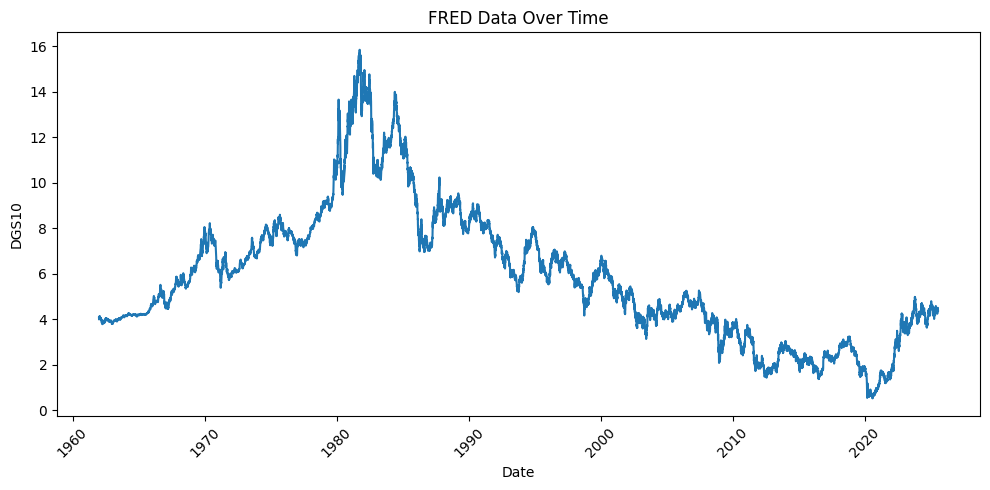

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['DGS10'])
plt.title('FRED Data Over Time')
plt.xlabel('Date')
plt.ylabel('DGS10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch


def build_model(hp, input_shape):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=True,
        input_shape=input_shape
    ))
    model.add(keras.layers.LSTM(
        units=hp.Int('lstm_units2', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(
        rate=hp.Float('dropout', min_value=0.2, max_value=0.7, step=0.1)
    ))
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='mae',
        metrics=[keras.metrics.RootMeanSquaredError()]
    )
    return model

def predict_and_evaluate_column_true_backtest_tuned(column_name):
    window = 60
    training_data_percent = .8

    industry = df.filter([column_name])
    dataset = industry.values
    training_data_len = int(np.ceil(len(dataset) * training_data_percent))

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)

    training_data = scaled_data[:training_data_len]

    x_train, y_train = [], []
    for i in range(window, len(training_data)):
        x_train.append(training_data[i-window:i, 0])
        y_train.append(training_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    tuner = RandomSearch(
        lambda hp: build_model(hp, (x_train.shape[1], 1)),
        objective='loss',
        max_trials=10,
        executions_per_trial=1,
        directory='tuner_dir',
        project_name='fred_lstm'
    )

    tuner.search(x_train, y_train, epochs=20, batch_size=32, verbose=1)
    best_model = tuner.get_best_models(num_models=1)[0]

    test_len = len(scaled_data) - training_data_len
    input_seq = scaled_data[training_data_len-window:training_data_len, 0].copy()
    predictions = []

    for i in range(test_len):
        x_input = np.array(input_seq).reshape((1, window, 1))
        pred = best_model.predict(x_input)
        predictions.append(pred[0, 0])
        input_seq = np.append(input_seq[1:], pred[0, 0])

    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    prediction_dates = df['Date'][training_data_len:].reset_index(drop=True)
    predictions_df = pd.DataFrame({'Date': prediction_dates, 'Predictions': predictions.flatten()})

    y_true = df[column_name][training_data_len:].reset_index(drop=True)
    y_pred = predictions_df['Predictions']
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return predictions_df, mape

In [31]:
predictions_df, mape = predict_and_evaluate_column_true_backtest_tuned('DGS10')

/home/tmher/Projects/project_groundhog/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
96                |96                |lstm_units
32                |32                |lstm_units2
128               |128               |dense_units
0.4               |0.4               |dropout
0.00017317        |0.00017317        |lr

Epoch 1/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.1516 - root_mean_squared_error: 0.2791
Epoch 2/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0840 - root_mean_squared_error: 0.1298
Epoch 3/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0795 - root_mean_squared_error: 0.1226
Epoch 4/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0759 - root_mean_squared_error: 0.1155
Epoch 5/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.0756 - root_mean_squared_error: 0.1181
Epoch 6/20
105/395 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0734 - root_mean_squared_error: 0.1150

KeyboardInterrupt: 

In [ ]:
def plot_predictions(column_name, predictions_df, mape):
    """
    Plots the actual data and predictions for a given column and prints the MAPE.

    Args:
        column_name (str): The name of the column being plotted.
        predictions_df (pandas.DataFrame): DataFrame with 'Date' and 'Predictions' columns.
        mape (float): The Mean Absolute Percentage Error (MAPE) for the column.
    """
    training_data_percent = .8

    train = df[:int(np.ceil( len(df) * training_data_percent ))]
    test = df[int(np.ceil( len(df) * training_data_percent )):]

    plt.figure(figsize=(12,8))
    plt.plot(train['Date'], train[column_name], label='Training Data', color='blue')
    plt.plot(test['Date'], test[column_name], label='Test Data', color='orange')
    plt.plot(predictions_df['Date'], predictions_df['Predictions'], label='Predictions', color='green')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.title(f'{column_name} Data')
    plt.legend()
    plt.show()
    print(f"Mean Absolute Percentage Error (MAPE) for {column_name}: {mape:.2f}%")

In [ ]:
plot_predictions('DGS10', predictions_df, mape)